In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

import matplotlib.pyplot as plt

/content/drive/MyDrive/Colab Notebooks/Trabajo Fin de Estudios/Dataset/train_drcat_01.csv
/content/drive/MyDrive/Colab Notebooks/Trabajo Fin de Estudios/Dataset/train_drcat_02.csv
/content/drive/MyDrive/Colab Notebooks/Trabajo Fin de Estudios/Dataset/train_drcat_03.csv
/content/drive/MyDrive/Colab Notebooks/Trabajo Fin de Estudios/Dataset/train_drcat_04.csv


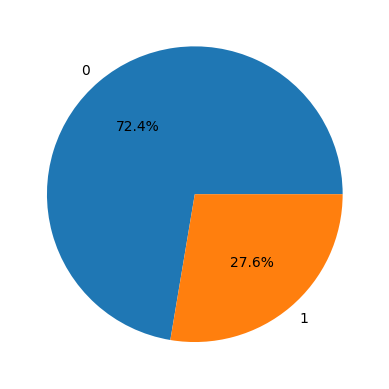

In [3]:
# Define la ruta a la carpeta
ruta_carpeta = '/content/drive/MyDrive/Colab Notebooks/Trabajo Fin de Estudios/Dataset/'

# Define los nombres de los archivos
nombres_archivos = ['train_drcat_01.csv', 'train_drcat_02.csv', 'train_drcat_03.csv', 'train_drcat_04.csv']
# Crea una lista vacía para almacenar los DataFrames
dfs = []

# Itera sobre los nombres de los archivos y lee cada uno en un DataFrame
for nombre_archivo in nombres_archivos:
    ruta_archivo = ruta_carpeta + nombre_archivo
    print(ruta_archivo)
    df = pd.read_csv(ruta_archivo, sep=",", encoding='utf-8')  # Ajusta el separador y la codificación si es necesario
    dfs.append(df)

# Concatena todos los DataFrames en uno solo
df_final = pd.concat(dfs, ignore_index=True)

# Mostramos las 5 primeras filas
df_final.head()

plt.pie(df_final['label'].value_counts().values,
        labels = df_final['label'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

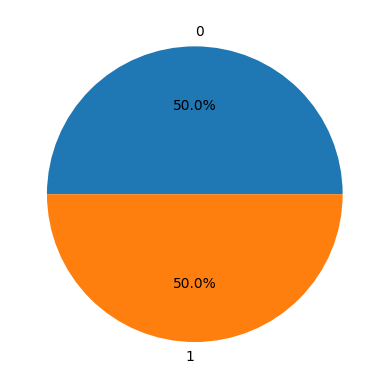

In [4]:
df_label_0 = df_final[df_final['label'] == 0].sample(n=2000, random_state=42)  # random_state para reproducibilidad

# Seleccionar 1000 textos con label 1
df_label_1 = df_final[df_final['label'] == 1].sample(n=2000, random_state=42)

# Concatenar los dos DataFrames
df_seleccionado = pd.concat([df_label_0, df_label_1])

# Reiniciar el índice
df_seleccionado = df_seleccionado.reset_index(drop=True)

plt.pie(df_seleccionado['label'].value_counts().values,
        labels = df_seleccionado['label'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

In [5]:
import tensorflow as tf
from tensorflow.keras import Model, layers, Input
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Configuración Inicial ---
vocab_size = 10000  # Tamaño del vocabulario
embedding_dim = 300  # Dimensión del embedding
sequence_length = 400  # Longitud máxima de secuencias
latent_dim = 128  # Dimensión del espacio latente
batch_size = 64
epochs = 20


# --- Carga y Preprocesamiento de Datos ---
df=df_seleccionado

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [7]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])

    # Lematizar palabras especificando el POS
    return text



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [8]:
# Eliminar registros nulos o vacíos en la columna de texto
df = df.dropna(subset=["text"])
df = df[df["text"].str.strip() != ""]
df['text_clean'] = df['text'].apply(preprocess_text)

In [9]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Vectorizador de texto
vectorizador = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',  # Para generar secuencias de índices
    output_sequence_length=sequence_length,
    ngrams=(1, 2)  #Adaptación del código para ngramas # Incluye unigramas y bigramas (puedes ajustar (1,3) para trigramas, etc.)

)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df['text_clean'], test_size=0.2, random_state=42)

print(X_train[:5])

3994    as an 8th grader i believe that life can be en...
423     have you ever asked someone for advice did you...
2991    dear principal\n\ni am writing to you today to...
1221    have you ever had a problem that you couldnt s...
506     a danger of ecploring venus is that the temper...
Name: text_clean, dtype: object


In [ ]:
print(type(X_train[0]))  # Debería ser <class 'str'>

<class 'str'>


In [11]:

#vectorizador.adapt(X_train)
vectorizador.adapt(df['text_clean'])
# Vectorize before batching
X_train_vec = [vectorizador(x) for x in X_train]  # Vectorize each text
X_test_vec = [vectorizador(x) for x in X_test]    # Vectorize each text

# Crear los datasets de entrada
train_dataset = tf.data.Dataset.from_tensor_slices(X_train_vec)  # Solo entradas, sin etiquetas
train_dataset = train_dataset.batch(batch_size).shuffle(len(X_train)).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(X_test_vec)  # Solo entradas, sin etiquetas
test_dataset = test_dataset.batch(batch_size).shuffle(len(X_test)).prefetch(tf.data.AUTOTUNE)

In [12]:
for batch in train_dataset.take(1):
    print(batch)  # Verifica que sea un tensor con los índices de las palabras

tf.Tensor(
[[3782 3696   16 ...  200    1    1]
 [ 631 3734   18 ...    0    0    0]
 [  57   26  216 ... 1320    1 3176]
 ...
 [  33   14   32 ...   53 6316  149]
 [ 361    2 4352 ...    1 8685 1364]
 [   1    1   28 ...   17 5540    4]], shape=(64, 400), dtype=int64)


In [13]:
for batch in test_dataset.take(1):
    print(batch)  # Verifica que sea un tensor con los índices de las palabras

tf.Tensor(
[[ 921   50   53 ...  700 5623    1]
 [  18 8402    8 ...    0    0    0]
 [  23  205   18 ...    1 6456    1]
 ...
 [  28   51 2231 ...    1    1  446]
 [ 921   50   53 ... 3284    1  399]
 [   2    1  265 ...    1    1    1]], shape=(64, 400), dtype=int64)


In [14]:
print(vectorizador.vocabulary_size())  # Asegúrate de que el vocabulario fue correctamente adaptado

10000


In [15]:

from tensorflow.keras.saving import register_keras_serializable
import tensorflow as tf
from tensorflow.keras import Model, layers, Input
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# --- Ajustes del optimizador ---
initial_lr = 1e-4  # Tasa de aprendizaje reducida
optimizer = Adam(learning_rate=initial_lr)

# --- Callbacks para mejorar convergencia ---
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True, verbose=1
)

# --- Definición del Encoder ---
encoder_inputs = Input(shape=(sequence_length,), name="encoder_input")
x = vectorizador(encoder_inputs)
x = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True, name="embedding_layer")(encoder_inputs)  # Embedding
x = layers.LSTM(sequence_length, return_sequences=False, use_cudnn=False, kernel_regularizer=regularizers.l2(0.01), name="encoder_lstm")(x)  # Reducimos unidades en LSTM y agregamos regularización L2
x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01), name="encoder_dense_1")(x)  # Regularización L2
x = layers.Dropout(0.4)(x)  # Dropout para prevenir overfitting
x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01), name="encoder_dense_2")(x)  # Regularización L2

# Parametrización de la distribución latente
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Reparametrización
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name="z_sampling")([z_mean, z_log_var])

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# --- Definición del Decoder ---
decoder_inputs = Input(shape=(latent_dim,), name="z_sampling_input")
x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01), name="decoder_dense")(decoder_inputs)  # Regularización L2
x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01), name="decoder_dense_1")(x)  # Regularización L2
x = layers.RepeatVector(sequence_length)(x)
decoder_outputs = layers.LSTM(sequence_length, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(x)  # Regularización L2
decoder_outputs = layers.TimeDistributed(layers.Dense(vocab_size, activation="softmax"))(decoder_outputs)
decoder = Model(decoder_inputs, decoder_outputs, name="decoder")


# --- Definición del Autoencoder ---
vae_outputs = decoder(encoder(encoder_inputs)[2])

def vae_loss(inputs, outputs, z_mean, z_log_var):
    # Reconstrucción: sparse crossentropy acepta inputs enteros directamente
    reconstruction_loss = tf.reduce_mean(
        tf.keras.losses.sparse_categorical_crossentropy(inputs, outputs)
    )

    # KL Divergence ajustada para evitar sumas grandes
    kl_loss = -0.5 * tf.reduce_mean(
        1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    )
    beta = 0.4  # Hiperparámetro de ajuste
    return reconstruction_loss + beta * kl_loss

def custom_mse(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)  # Obtener los tokens con mayor probabilidad

    # Convertir a enteros
    y_pred = tf.cast(y_pred, tf.int32)  # Convertir y_pred a tf.int32

    # Calcular MSE solo en la dimensión de la secuencia
    mse = tf.keras.losses.MeanSquaredError()(y_true, y_pred)

    return mse

# --- Definición del modelo con `train_step` personalizado ---
from tensorflow.keras.metrics import MeanSquaredError
@register_keras_serializable()
class VAEModel(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAEModel, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z), z_mean, z_log_var
        #return self.decoder(z)

    def get_config(self):
        config = super().get_config()
        config.update({
            "encoder": self.encoder,
            "decoder": self.decoder
        })
        return config

    @classmethod
    def from_config(cls, config):
        encoder = config.pop("encoder")
        decoder = config.pop("decoder")
        return cls(encoder, decoder, **config)

    def train_step(self, data):
        self.reset_metrics()  # Reinicia las métricas antes de cada paso
        with tf.GradientTape() as tape:
            inputs = data
            outputs, z_mean, z_log_var = self(inputs, training=True)
            loss = vae_loss(inputs, outputs, z_mean, z_log_var)

        # Computar gradientes
        grads = tape.gradient(loss, self.trainable_variables)

        # Actualizar los pesos
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        # Actualizar la métrica de accuracy
        mse=custom_mse(inputs, outputs)

        return {"loss": loss, "custom_mse": mse}  # Cambiar el nombre de la métrica en el diccionario de salida

    def test_step(self, data):
        self.reset_metrics()  # Reinicia las métricas antes del paso de prueba
        inputs = data
        outputs, z_mean, z_log_var = self(inputs, training=False)
        loss = vae_loss(inputs, outputs, z_mean, z_log_var)

        mse=custom_mse(inputs, outputs)
        return {"loss": loss, "custom_mse": mse}  # Cambiar el nombre de la métrica en el diccionario de salida

from tensorflow.keras.callbacks import LearningRateScheduler

def print_lr(epoch, lr):
    print(f"Epoch: {epoch + 1}, Learning Rate: {lr}")

lr_callback = LearningRateScheduler(lambda epoch, lr: lr, verbose=1)
# Crear el modelo VAE
vae_model = VAEModel(encoder, decoder)



Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - custom_mse: 4783700.5000 - loss: 8.2755 - val_custom_mse: 3294840.5000 - val_loss: 6.9700 - learning_rate: 1.0000e-04
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - custom_mse: 3340645.7500 - loss: 6.4126 - val_custom_mse: 3294840.5000 - val_loss: 6.2722 - learning_rate: 1.0000e-04
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - custom_mse: 3339480.5000 - loss: 6.2160 - val_custom_mse: 3536982.7500 - val_loss: 6.1999 - learning_rate: 1.0000e-04
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - custom_mse: 3344228.2500 - loss: 6.2102 - val_custom_mse: 3383715.0000 - val_loss: 6.2443 - learning_rate: 1.0000e-04
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - custom_mse: 3348991.2500 - loss: 6.2102 - val_custom_mse: 3222028.7500 - val_loss: 6.2425 - learning_rate: 1.0000e-04
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - custom_mse: 3340833.7500 - loss: 6.2068 - val_custom_mse: 3536982.7500 - val_loss: 6.1954 - learni

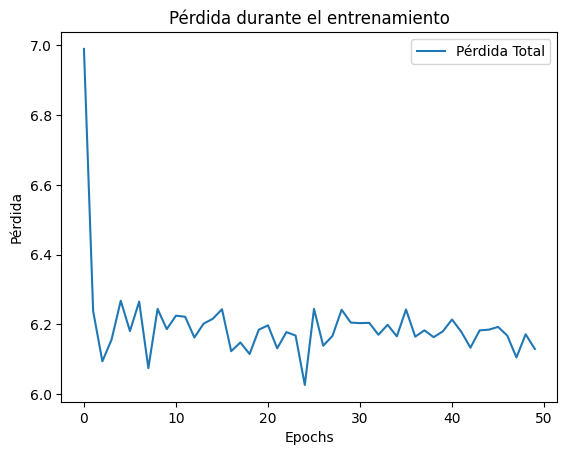

In [16]:

vae_model.compile(optimizer=optimizer)  # No es necesario definir loss directamente aquí

history = vae_model.fit(
    train_dataset,              # Datos de entrada para entrenamiento
    batch_size=batch_size,
    epochs=50,                  # Número de épocas de entrenamiento
    validation_data=test_dataset,  # Datos de validación para evaluar el modelo
    callbacks=[lr_scheduler],
    verbose=1                   # Muestra el progreso durante el entrenamiento
)
# --- Visualización de la pérdida ---
plt.plot(history.history["loss"], label="Pérdida Total")
plt.title("Pérdida durante el entrenamiento")
plt.xlabel("Epochs")
plt.ylabel("Pérdida")
plt.legend()
plt.show()


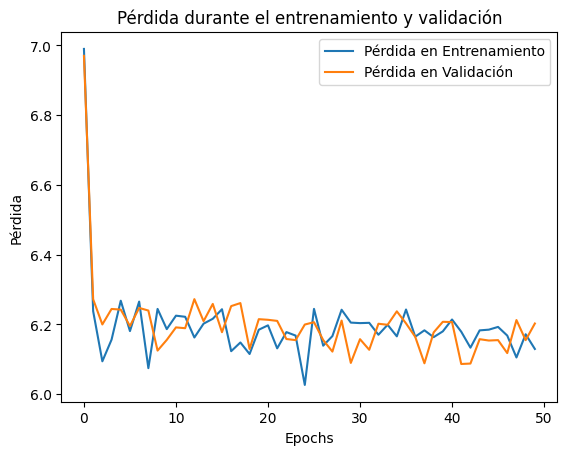

In [17]:
plt.plot(history.history["loss"], label="Pérdida en Entrenamiento")
plt.plot(history.history["val_loss"], label="Pérdida en Validación")
plt.title("Pérdida durante el entrenamiento y validación")
plt.xlabel("Epochs")
plt.ylabel("Pérdida")
plt.legend()
plt.show()